## Case Study 3 : Machine Learning - Textual Analysis Of Movie Reviews

**TEAM Member:**
Matt Curcio

**Desired outcome of the case study.**
* In this case study we will look at movie reviews from the v2.0 polarity dataset comes from: <br> http://www.cs.cornell.edu/people/pabo/movie-review-data.
    * It contains written reviews of movies divided into positive and negative reviews.
* As in Case Study 2 idea is to *analyze* the data set, make *conjectures*, support or refute those conjectures with *data*, and *tell a story* about the data!
    
**Required Readings:** 
* This case study will be based upon the scikit-learn Python library
* We will build upon the turtorial "Working With Text Data" which can be found at: <br> http://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html

**Required Python libraries:**
* Numpy (http://www.numpy.org)
* Matplotlib (http://matplotlib.org)
* Scikit-learn (http://scikit-learn.org)


## Problem 1: Complete Exercise 2: Sentiment Analysis on movie reviews from

http://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html

* Assuming that you have downloaded the scikit-learn source code:
    * The data cane be downloaded using doc/tutorial/text_analytics/data/movie_reviews/fetch_data.py
    * A skeleton for the solution can be found in doc/tutorial/text_analytics/skeletons/exercise_02_sentiment.py
    * A completed solution can be found in doc/tutorial/text_analytics/solutions/exercise_02_sentiment.py
* **It is ok to use the solution provided in the scikit-learn distribution as a starting place for your work.**

#### Modify the solution to Exercise 2 so that it can run in this iPython notebook
* This will likely involved moving around data files and/or small modifications to the script.

In [1]:
import os
import tarfile
try:
    from urllib import urlopen
except ImportError:
    from urllib.request import urlopen

URL = ('http://www.cs.cornell.edu/people/pabo/movie-review-data/review_polarity.tar.gz')

ARCHIVE_NAME = URL.rsplit('/', 1)[1]
DATA_FOLDER = 'txt_sentoken'

if not os.path.exists(DATA_FOLDER):

    if not os.path.exists(ARCHIVE_NAME):
        print('Downloading dataset from %s (3 MB)' % URL)
        opener = urlopen(URL)
        open(ARCHIVE_NAME, 'wb').write(opener.read())

    print('Decompressing %s' % ARCHIVE_NAME)
    tarfile.open(ARCHIVE_NAME, "r:gz").extractall(path='.')
    os.remove(ARCHIVE_NAME)

In [2]:
import sys
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.datasets import load_files
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

movie_reviews_data_folder = 'txt_sentoken'
dataset = load_files(movie_reviews_data_folder, shuffle=False)
print('n_samples: %d' % len(dataset.data))

n_samples: 2000


In [3]:
# split the dataset in training and test set:
docs_train, docs_test, y_train, y_test = train_test_split(dataset.data, dataset.target, test_size=0.25, random_state=None)

# Build a vectorizer / classifier pipeline that filters out tokens
# that are too rare or too frequent
pipeline = Pipeline([
  ('vect', TfidfVectorizer(min_df=3, max_df=0.95, ngram_range=(1, 1))),
  ('clf', LinearSVC(C=1000))
])

# Fit the pipeline on the training set using grid search for the parameters
parameters = {}
grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1)
grid_search.fit(docs_train, y_train)

# print the cross-validated scores for the each parameters set
# explored by the grid search
print(grid_search.grid_scores_)

# Predict the outcome on the testing set and store it in a variable
# named y_predicted
y_predicted = grid_search.predict(docs_test)

# Print the classification report
print(metrics.classification_report(y_test, y_predicted, target_names=dataset.target_names))

# Print and plot the confusion matrix
cm = metrics.confusion_matrix(y_test, y_predicted)
print(cm)

[mean: 0.83533, std: 0.01221, params: {}]
             precision    recall  f1-score   support

        neg       0.85      0.84      0.85       248
        pos       0.84      0.86      0.85       252

avg / total       0.85      0.85      0.85       500

[[208  40]
 [ 36 216]]


## Problem 2: Explore the scikit-learn TfidVectorizer class

**Read the documentation for the TfidVectorizer class at: <br> http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html.** 
* Define the term frequency–inverse document frequency (TF-IDF) statistic (http://en.wikipedia.org/wiki/Tf%E2%80%93idf will likely help).
* Run the TfidVectorizer class on the training data above (docs_train).
* Explore the min_df and max_df parameters of TfidVectorizer.  What do they mean? How do they change the features you get?
* Explore the ngram_range parameter of TfidVectorizer.  What does it mean? How does it change the features you get? (Note, large values  of ngram_range may take a long time to run!)

#### TF-IDF:
A measure of how relevant a word is to a document in a collection of documents. The TF-IDF statistic of a word gets bigger as the word appears more often inside a document, but is penalized by how common the word is considering the entire collection of documents.

#### min_df and max_df:
The parameters min_df and max_df control the threshold of the term frequencies included in the analysis. The values used in problem 1 (min_df=3 and max_df=0.95) mean that for a word to be considered in the analysis it should appear at least 3 times in the document and at most in 95% of the documents in the collection.

By changing these 2 parameters we essentially modify the number of features available to create our classification model. The lower the threshold for min_df the more words you consider for analysis as you start to include very uncommon words. Similarly the higher the threshold for max_df the more words are included for analysis as you start to include very common words. A balance must be found when setting these parameters as we definitely don't want to include words that are very common like prepositions, connective words, etc. and we don't want to exclude some adjetives that are uncommon but are really aligned with the sentiment of the text such as awful, adorable, etc.

In [4]:
# Build a vectorizer / classifier pipeline that filters out tokens
# that are too rare or too frequent
pipeline = Pipeline([
  ('vect', TfidfVectorizer(ngram_range=(1, 1))),
  ('clf', LinearSVC(C=1000))
])

# Build a grid search to find out best min_df and max_df.
# Fit the pipeline on the training set using grid search for the parameters
parameters = { 
    'vect__min_df': range(1, 5),
    'vect__max_df': [0.85, 0.86, 0.87, 0.88, 0.89, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95]
}
grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1)
grid_search.fit(docs_train, y_train)

print 'Best parameters for TfidfVectorizer:'
best_parameters, score, _ = max(grid_search.grid_scores_, key=lambda x: x[1])
for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))
print

# Predict the outcome on the testing set and store it in a variable
# named y_predicted
y_predicted = grid_search.predict(docs_test)

# Print the classification report
print(metrics.classification_report(y_test, y_predicted, target_names=dataset.target_names))

# Print and plot the confusion matrix
cm = metrics.confusion_matrix(y_test, y_predicted)
print(cm)

Best parameters for TfidfVectorizer:
vect__max_df: 0.87
vect__min_df: 2

             precision    recall  f1-score   support

        neg       0.85      0.86      0.85       248
        pos       0.86      0.85      0.85       252

avg / total       0.85      0.85      0.85       500

[[213  35]
 [ 38 214]]


#### ngram-range:
This parameter sets the range of combined words that are used as a feature. This is necessary because for some words we need the context to correctly mark it a positive or negative meaning. For instance the "good" has generally a positive meaning but if it preceeded by the word "not" then it has a negative meaning.
Using a ngram-range of (1,2) helps in this case as we would consider "not good" as a feature also and not just "good".

In [5]:
# Build a vectorizer / classifier pipeline that filters out tokens
# that are too rare or too frequent
pipeline = Pipeline([
  ('vect', TfidfVectorizer(min_df=4, max_df=0.95)),
  ('clf', LinearSVC(C=1000))
])

# Build a grid search to find out best value for ngram range.
# Fit the pipeline on the training set using grid search for the parameters
parameters = { 'vect__ngram_range': [(1, 1), (1, 2), (1, 3), (2, 2), (2, 3), (3, 3)] }
grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1)
grid_search.fit(docs_train, y_train)

print 'Best parameters for TfidfVectorizer:'
best_parameters, score, _ = max(grid_search.grid_scores_, key=lambda x: x[1])
for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))
print

# Predict the outcome on the testing set and store it in a variable
# named y_predicted
y_predicted = grid_search.predict(docs_test)

# Print the classification report
print(metrics.classification_report(y_test, y_predicted, target_names=dataset.target_names))

# Print and plot the confusion matrix
cm = metrics.confusion_matrix(y_test, y_predicted)
print(cm)

Best parameters for TfidfVectorizer:
vect__ngram_range: (1, 2)

             precision    recall  f1-score   support

        neg       0.87      0.85      0.86       248
        pos       0.85      0.88      0.86       252

avg / total       0.86      0.86      0.86       500

[[210  38]
 [ 31 221]]


## Problem 3: Machine learning algorithms

* Based upon Problem 2 pick some parameters for TfidfVectorizer
    * "fit" your TfidfVectorizer using docs_train
    * Compute "Xtrain", a Tf-idf-weighted document-term matrix using the transform function on docs_train
    * Compute "Xtest", a Tf-idf-weighted document-term matrix using the transform function on docs_test
    * Note, be sure to use the same Tf-idf-weighted class (**"fit" using docs_train**) to transform **both** docs_test and docs_train
* Examine two classifiers provided by scikit-learn 
    * LinearSVC
    * KNeighborsClassifier
    * Try a number of different parameter settings for each and judge your performance using a confusion matrix (see Problem 1 for an example).
* Does one classifier, or one set of parameters work better?
    * Why do you think it might be working better?
* For a particular choice of parameters and classifier, look at 2 examples where the prediction was incorrect.
    * Can you conjecture on why the classifier made a mistake for this prediction?

In [6]:
# Build a vectorizer / classifier pipeline that filters out tokens
# that are too rare or too frequent
tfidf_vectorizer = TfidfVectorizer(min_df=4, max_df=0.95, ngram_range=(1, 3))

# train on docs_test and build XTrain and XTest
XTrain = tfidf_vectorizer.fit_transform(docs_train)
XTest = tfidf_vectorizer.transform(docs_test)

In [7]:
# use LinearSVC to predict classes
classifier = LinearSVC()

pipeline = Pipeline([
  ('clf', classifier)
])

# Build a grid search to find out the best parameters
# Fit the pipeline on the training set using grid search for the parameters
parameters = { 'clf__C': range(1, 16000, 1000) }
grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1)
grid_search.fit(XTrain, y_train)

print 'Best parameters for LinearSVC:'
best_parameters, score, _ = max(grid_search.grid_scores_, key=lambda x: x[1])
for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))
print

#classifier.fit(XTrain, y_test)
y_predicted = grid_search.predict(XTest)

# Print the classification report
print(metrics.classification_report(y_test, y_predicted, target_names=dataset.target_names))

# Print and plot the confusion matrix
cm = metrics.confusion_matrix(y_test, y_predicted)
print(cm)

Best parameters for LinearSVC:
clf__C: 1001

             precision    recall  f1-score   support

        neg       0.85      0.86      0.86       248
        pos       0.86      0.85      0.86       252

avg / total       0.86      0.86      0.86       500

[[214  34]
 [ 37 215]]


In [8]:
# use KNN to predict classes
classifier = KNeighborsClassifier()

pipeline = Pipeline([
  ('clf', classifier)
])

# Build a grid search to find out the best parameters
# Fit the pipeline on the training set using grid search for the parameters
parameters = { 
    'clf__n_neighbors': range(1, 15),
    'clf__weights': ('uniform', 'distance')
}
grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1)
grid_search.fit(XTrain, y_train)

print 'Best parameters for KNN:'
best_parameters, score, _ = max(grid_search.grid_scores_, key=lambda x: x[1])
for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))
print

#classifier.fit(XTrain, y_test)
y_predicted = grid_search.predict(XTest)

# Print the classification report
print(metrics.classification_report(y_test, y_predicted, target_names=dataset.target_names))

# Print and plot the confusion matrix
cm = metrics.confusion_matrix(y_test, y_predicted)
print(cm)

Best parameters for KNN:
clf__n_neighbors: 10
clf__weights: 'uniform'

             precision    recall  f1-score   support

        neg       0.73      0.63      0.68       248
        pos       0.68      0.77      0.72       252

avg / total       0.70      0.70      0.70       500

[[156  92]
 [ 58 194]]


#### Conjecture about the errors:
* We chose to investigate some errors using LinearSVC since for it gave the best predictions for us (with around 81% accuracy) while still having room for improvement.

In [9]:
# use LinearSVC to predict classes
classifier = LinearSVC(C=1001)

classifier.fit(XTrain, y_train)
y_predicted = classifier.predict(XTest)

false_positive_index = -1
false_negative_index = -1
for i in range(len(y_train)):
    if y_test[i] == 0 and y_predicted[i] == 1 and false_positive_index == -1:
        false_positive_index = i
    if y_test[i] == 1 and y_predicted[i] == 0 and false_negative_index == -1:
        false_negative_index = i
    if false_positive_index > 0 and false_negative_index > 0:
        break

print 'Example of false positive:'
print docs_test[false_positive_index]
print

print 'Example of false negative:'
print docs_test[false_negative_index]
print

Example of false positive:
joe versus the volcano is really one of the worse movies made in very recent memory . 
the strangest thing is that you would think nothing would go wrong with it . 
it has a solid cast with tom hanks & meg ryan as the lead roles . 
but you can never judge a movie by its cast . . . 
if there is one good thing about joe vs the volcano , it is that the plot is original . 
unfortunately , it is also incredibly stupid . 
the movie begins with joe ( tom hanks ) going to work . 
this opening sequence is very boring and slow . 
it shows joe walking to his office . 
but on the way , he has to wait in a long line passing by strange and slightly depressing scenery with obnoxious lighting . 
a sequence like this should take 2 minutes . 
here , it takes over 5 . . . 
it is obvious that joe hates his job . 
at his office , one of his co-workers is meg ryan . 
oddly enough , she plays 3 different roles in this movie ! ! 
joe leaves to go to a doctor's appointment . 
his doc

## Problem 4: Open Ended Question:  Finding the right plot

* Can you find a two dimensional plot in which the positive and negative reviews are separated?
    * This problem is hard since you will likely have thousands of features for review, and you will need to transform these thousands of features into just two numbers (so that you can make a 2D plot).
* Note, I was not able to find such a plot myself!
    * So, this problem is about **trying** but perhaps **not necessarily succeeding**!
* I tried two things, neither of which worked very well.
    * I first plotted the length of the review versus the number of features we compute that are in that review
    * Second I used Principle Component Analysis on a subset of the features.
* Can you do better than I did!?

The most important features are:
bad
mulan



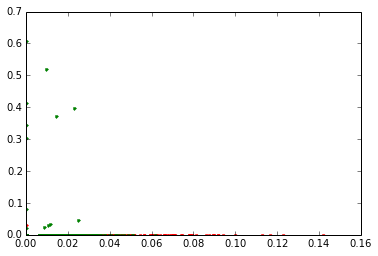

In [10]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
import matplotlib.pylab as py

tfidf_vectorizer = TfidfVectorizer(min_df=4, max_df=0.95, ngram_range=(1, 3))

# train on docs_test and build XTrain and XTest
XTrain = tfidf_vectorizer.fit_transform(docs_train)
XTest = tfidf_vectorizer.transform(docs_test)

features = tfidf_vectorizer.get_feature_names()

selector = SelectKBest(chi2, k=2)
X_train = selector.fit_transform(XTrain, y_train)
X_test = selector.transform(XTest)

support = selector.get_support()
print 'The most important features are:'
for i in range(len(support)):
    if support[i]:
        print features[i]
print

X = X_train.toarray()
Xte = X_test.toarray()

# negative
py.plot(X[y_train==0,0], X[y_train==0,1],'r.')
py.plot(Xte[y_test==0,0], Xte[y_test==0,1],'r.')
# positive
py.plot(X[y_train==1,0], X[y_train==1,1],'g.')
py.plot(Xte[y_test==1,0], Xte[y_test==1,1],'g.')
py.show()

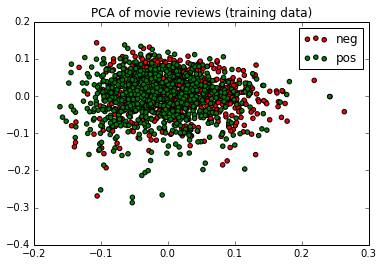

In [11]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_r = pca.fit_transform(XTrain.toarray())

target_names = dataset.target_names

plt.figure()
for c, i, target_name in zip("rgb", [0, 1], target_names):
    plt.scatter(X_r[y_train == i, 0], X_r[y_train == i, 1], c=c, label=target_name)
plt.legend()
plt.title('PCA of movie reviews (training data)')

plt.show()

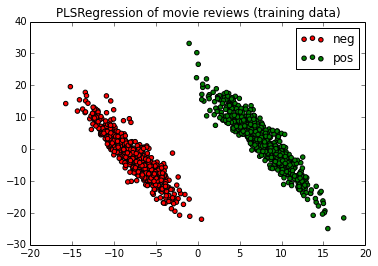

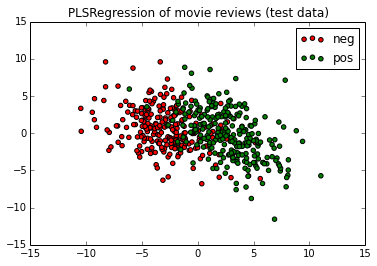

In [12]:
from sklearn.cross_decomposition import PLSRegression

pls = PLSRegression(n_components=2, scale=True)
pls.fit(XTrain.toarray(), y_train)
X_trained = pls.transform(XTrain.toarray())
X_tested = pls.transform(XTest.toarray())

target_names = dataset.target_names

plt.figure()
for c, i, target_name in zip("rgb", [0, 1], target_names):
    plt.scatter(X_trained[y_train == i, 0], X_trained[y_train == i, 1], c=c, label=target_name)
plt.legend()
plt.title('PLSRegression of movie reviews (training data)')

plt.figure()
for c, i, target_name in zip("rgb", [0, 1], target_names):
    plt.scatter(X_tested[y_test == i, 0], X_tested[y_test == i, 1], c=c, label=target_name)
plt.legend()
plt.title('PLSRegression of movie reviews (test data)')

plt.show()

# Done

** What do you need to submit?**

* **Notebook File**: Save this IPython notebook, and find the notebook file in your folder (for example, "filename.ipynb"). This is the file you need to submit. Please make sure all the plotted tables and figures are in the notebook. If you used "ipython notebook --pylab=inline" to open the notebook, all the figures and tables should have shown up in the notebook.

* **PPT Slides**: please prepare PPT slides (for 10 minutes' talk) to present about the case study . We will ask two teams which are randomly selected to present their case studies in class for this case study. 

* ** Report**: please prepare a report (less than 10 pages) to report what you found in the data.
    * How did you analyse the data?
    * What did you find in the data? 
    * What classifier worked better?
    * Which parameters worked better?
    * Did you come up with a good plot?

     (please include figures or tables in the report, but no source code)

Please compress all the files in a zipped file.
